<a href="https://colab.research.google.com/github/Zobia12/EEG_Based_Human_Emotion_Recognition_Using_Deep_Learning/blob/main/EEG_based_Emotion_Recognition_Using_CNN_model(with_32_channels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-x244z33y
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-x244z33y
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=b8b0969cfc2cff3d346bb11b7065543b0e74123d304ecca70a459b8af3661339
  Stored in directory: /tmp/pip-ephem-wheel-cache-ng52nf40/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


In [2]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# data_preprocessed_python
os.getcwd()
os.chdir('/content/drive/My Drive')

In [5]:
channel = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32] #32 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands THETA, ALPHA, ALPHA, BETA, BETA, BETA, GAMMA.
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']
#List of subjects

In [6]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/drive/My Drive/leading_ai/try/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/My Drive/leading_ai/try/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [7]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [8]:

data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/My Drive/leading_ai/try/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/leading_ai/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/leading_ai/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/leading_ai/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/leading_ai/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (46848, 155) (46848, 4)
testing dataset: (11712, 155) (11712, 4)


In [9]:

with open('/content/drive/My Drive/leading_ai/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/content/drive/My Drive/leading_ai/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [10]:
X.shape

(46848, 155)

In [11]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
y_train.shape

(46848, 10)

In [13]:
x_train = np.array(X[:])

In [14]:

with open('/content/drive/My Drive/leading_ai/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/content/drive/My Drive/leading_ai/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [15]:
x_test = np.array(M[:])

In [16]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [19]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [20]:
x_train.shape

(46848, 155, 1)

In [21]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(x_train.shape[1], 1)

In [22]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [23]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 155, 128)          512       
                                                                 
 batch_normalization (BatchN  (None, 155, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 77, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 77, 128)           49280     
                                                                 
 batch_normalization_1 (Batc  (None, 77, 128)          512       
 hNormalization)                                                 
                                                        

In [24]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,  
          verbose=1,validation_data=(x_test,y_test))

Epoch 1/200
183/183 [==============================] - 63s 339ms/step - loss: 1.7669 - accuracy: 0.3183 - val_loss: 1.6805 - val_accuracy: 0.2990
Epoch 2/200
183/183 [==============================] - 63s 345ms/step - loss: 1.4524 - accuracy: 0.4239 - val_loss: 1.3740 - val_accuracy: 0.4483
Epoch 3/200
183/183 [==============================] - 62s 336ms/step - loss: 1.2799 - accuracy: 0.4879 - val_loss: 1.1189 - val_accuracy: 0.5470
Epoch 4/200
183/183 [==============================] - 63s 346ms/step - loss: 1.1615 - accuracy: 0.5390 - val_loss: 1.0111 - val_accuracy: 0.6008
Epoch 5/200
183/183 [==============================] - 61s 334ms/step - loss: 1.0743 - accuracy: 0.5739 - val_loss: 0.9033 - val_accuracy: 0.6375
Epoch 6/200
183/183 [==============================] - 61s 333ms/step - loss: 0.9899 - accuracy: 0.6069 - val_loss: 0.8374 - val_accuracy: 0.6712
Epoch 7/200
183/183 [==============================] - 62s 341ms/step - loss: 0.9375 - accuracy: 0.6286 - val_loss: 0.7749 -

In [26]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

366/366 [==============================] - 5s 13ms/step - loss: 0.3429 - accuracy: 0.9226
Test loss: 0.3428571820259094
Test accuracy: 0.922558069229126


In [27]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
import numpy


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


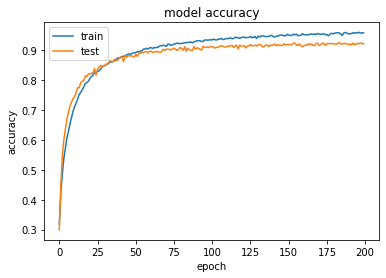

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

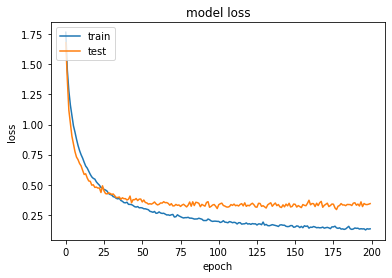

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

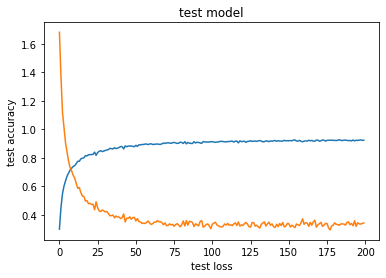

In [30]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

In [31]:
y_pred=model.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np

In [32]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [33]:
y_pred[1]

array([4.7491570e-35, 3.4963179e-08, 6.4950930e-35, 7.7418016e-11,
       8.4423642e-11, 1.1642030e-05, 3.9272541e-06, 9.9998248e-01,
       6.4356607e-07, 1.3129223e-06], dtype=float32)

In [34]:
y_test1=np.argmax(y_test, axis=1)

In [35]:
y_pred=np.argmax(y_pred,axis=1)

In [36]:
y_test1[1]

7

In [37]:
y_pred[1]

7

In [38]:
cmatrix=confusion_matrix(y_test1, y_pred)

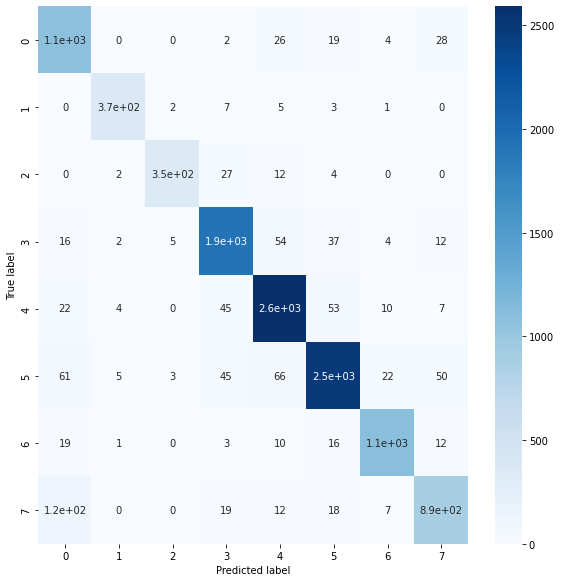

In [41]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()